<a href="https://colab.research.google.com/github/Jungin1020/Aiffel_exp/blob/main/2022_02_13_DCGAN_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##DCGAN으로 Cifar-10 이미지 생성하기

모델 구조, learing rate, 파라미터 초기화, Adversarial 관계, 데이터 특성 등을 잘 고려하자

MNIST와 다른 점

입력이미지 (32,32,3)

RGB 3채널

입력데이터 차원 3~4배

##1. 작업환경 구성하기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
'''
!mkdir -p /content/drive/MyDrive/aiffel/dcgan_newimage/cifar10/generated_samples
!mkdir -p /content/drive/MyDrive/aiffel/dcgan_newimage/cifar10/training_checkpoints
!mkdir -p /content/drive/MyDrive/aiffel/dcgan_newimage/cifar10/training_history
'''

'\n!mkdir -p /content/drive/MyDrive/aiffel/dcgan_newimage/cifar10/generated_samples\n!mkdir -p /content/drive/MyDrive/aiffel/dcgan_newimage/cifar10/training_checkpoints\n!mkdir -p /content/drive/MyDrive/aiffel/dcgan_newimage/cifar10/training_history\n'

In [ ]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print(tf.__version__)

2.7.0


##2. 데이터셋 구성하기

In [ ]:
from tensorflow.keras.datasets import cifar10
(train_image, train_label),(test_image, test_label) = cifar10.load_data()

170508288/170498071 [==============================] - 3s 0us/step


In [ ]:
bird=2
cat=3
deer=4
dog=5
frog=6
horse=7

condition_train = (train_label[:,0]==deer) #| (train_label[:,0]==frog)
condition_test = (test_label[:,0]==deer) #| (test_label[:,0]==frog)

x_train = train_image[condition_train]
x_test = test_image[condition_test]

print(x_train.shape)
print(x_test.shape)

(5000, 32, 32, 3)
(1000, 32, 32, 3)


데이터 일부만 가져오기
https://skettee.github.io/post/convolutional_neural_network/

In [ ]:
#x_train = (x_train-127.5)/127.5
x_train = x_train/255.0
print('max pixel:',x_train.max())
print('min pixel:',x_train.min())

max pixel: 1.0
min pixel: 0.0


각 픽셀을 0,1로 정규화 하기

In [ ]:
x_train = x_train.reshape(x_train.shape[0],32,32,3).astype('float32')
x_train.shape

(5000, 32, 32, 3)

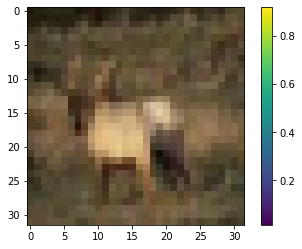

In [ ]:
plt.imshow(x_train[0].reshape(32,32,3))
plt.colorbar()
plt.show()

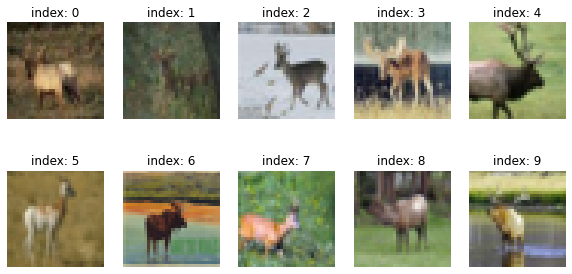

In [ ]:
plt.figure(figsize=(10,5))

for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(x_train[i].reshape(32,32,3))
  plt.title(f'index: {i}')
  plt.axis('off')
plt.show()

In [ ]:
BUFFER_SIZE = 5000
BATCH_SIZE = 32

train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

미니배치 만들기!

##3. 생성자모델 구현하기

In [ ]:
def make_generator_model():
  model = tf.keras.Sequential()

  model.add(layers.Dense(8*8*256, use_bias= False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((8,8,256)))

  model.add(layers.Conv2DTranspose(128, kernel_size=(5,5), strides=(1,1), padding='same',use_bias=False)) # (7,7,256) -> (7,7,128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, kernel_size=(5,5), strides=(2,2), padding='same',use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(3, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False, activation='sigmoid'))

  return model

In [ ]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 128)        5

###입력할 노이즈 벡터 만들기

In [ ]:
noise = tf.random.normal([1,100])

generated_image = generator(noise, training = False)
generated_image.shape

TensorShape([1, 32, 32, 3])

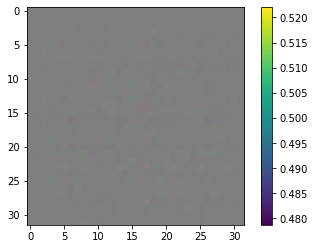

In [ ]:
plt.imshow(generated_image[0,:,:,:]) #plt는 2차원 이미지만 보여줄 수 있으므로 0,3번쨰 축의 인덱스를 0으로 설정해서 (32,32) shape의 이미지를 꺼내게 함
plt.colorbar()
plt.show()

##4. 판별자모델 구현하기

In [ ]:
def make_discriminator_model():
  model = tf.keras.Sequential()

  model.add(layers.Conv2D(64,(5,5), strides=(2,2), padding='same',input_shape=[32,32,3]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))
  
  model.add(layers.Conv2D(128,(5,5), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())

  model.add(layers.Dense(1))

  return model

In [ ]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)             

In [ ]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.09422136]], dtype=float32)>

노이즈 이미지를 판별자에 입력하면 아직은 의미 없는 값이 나온다

##5. 손실함수와 최적화함수 구현하기

###cross_entropy를 활용해 계산할 loss들은 fake_output과 real_output 두가지 활용

fake_output - 생성자가 fake image를 판별자에게 입력시켜 판별된 값

real_output - 기존에 있던 real image를 판별자에게 입력시켜 판별된 값

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) # from_logits를 해줘야 모든 실수값이 시그모이드를 거쳐 0~1값을 가지게 됨
#BinaryCorssEntropy 의 input 값이 0~1 사이여야하기 때문

In [ ]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output),fake_output)

def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss 

tf.ones_like() / tf.zeros_like()

특정 벡터와 동일한 크기에 1,0 을 가득 채움

생성자는 fake output이 1에 가까울수록(잘 그릴 수록) loss 값이 작아짐

판별자는 real_output 값이 1에, fake_output이 0에 가까워지기를 바란다

###Discriminator accuracy

accuracy가 1에 가까우면 real과 fake의 차이가 많이 나 판별자가 너무 쉽게 구분한다는 뜻

In [ ]:
def discriminator_accuracy(real_output, fake_output):
  #real_output의 텐서 원소를 0.5보다 큰지 작은지 구분해서 true면 1 false면 0으로 변환 > 결과를 평균내어 이번 배치의 정확도를 계산
  real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])),tf.float32)) 
  fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])),tf.float32))
  return real_accuracy, fake_accuracy

###Optimizer

생성자, 판별자 따로 학습하는 개별 네트워크이기 때문에 optimizer도 따로

learning rate 바꿔가면서 학습 진행해보기

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


#매번 학습이 어떻게 진행되고 있는지 확인하기 위해 생성자가 생성한 샘플을 확인
#한번에 100차원의 노이즈 16장
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

##6. 훈련과정 상세 기능 구현하기

하나의 미니배치 당 진행할 train_step 함수를 만든다

@tf.function이라는 데코레이터를 사용해서

(tensorflow의 graph 노드가 될 수 있는 타입으로 자동 변환)

###한번의 train_step

In [ ]:
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True) #generator가 노이즈를 입력 받아서 generated_image 생성

    #discriminator 판별
    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    #loss 계산
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

    #accuracy 계산
    real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)

  #gradient 계산
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  #계산된 gradient를 optimizer에 입력해 가중치 갱신
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  return gen_loss, disc_loss, real_accuracy, fake_accuracy

    

###train step과 함께 일정 간격으로 학습 현황을 볼 수 있는 샘플을 생성하는 함수

In [ ]:
def generate_and_save_images(model, epoch, it, sample_seeds):

  predictions = model(sample_seeds, training=False)

  fig = plt.figure(figsize=(4,4))
  for i in range(predictions.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(predictions[i,:,:,:])
    plt.axis('off')

  plt.savefig('/content/drive/MyDrive/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'.format(epoch, it))
  plt.show()

16개 seed가 들어있는 sample_seeds를 입력 받아서 만들어낸 prediction을 plt로 시각화해주는 과정

###tran_step()함수가 리턴하는 loss, accuray 값을 history 라는 dict구조에 저장하고 있다가 매 epoch 마다 시각화 하는 함수

In [ ]:
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 15,6 #차트 기본 크기 지정

def draw_train_history(history, epoch):
  plt.subplot(221)
  plt.plot(history['gen_loss'])
  plt.plot(history['disc_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('batch_iters')
  plt.legend(['gen_loss', 'disc_loss'], loc='upper left')

  plt.subplot(222)
  plt.plot(history['fake_accuracy'])
  plt.plot(history['real_accuracy'])
  plt.title('discriminator accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('batch_iters')
  plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')

  plt.savefig('/content/drive/MyDrive/aiffel/dcgan_newimage/cifar10/training_history/training_history_{:04d}.png'.format(epoch))
  plt.show()

###정기적으로 모델을 저장하기 위한 checkpoint 만들기
tf.train.Checkpoint - 매번 모델을 직접 저장해 주지 않아도 코드 한줄로 빠르고 편하게 버전 관리를 할 수 있다.

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/aiffel/dcgan_newimage/cifar10/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

##7. 학습과정 진행하기

train_step, generate_and_save_images(), draw_train_history(), checkpoint 한곳에 합치기


In [ ]:
def train(dataset, epochs, save_every):
  start = time.time()
  history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

  for epoch in range(epochs):
    epoch_start = time.time()
    for it, image_batch in enumerate(dataset):
      gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
      history['gen_loss'].append(gen_loss)
      history['disc_loss'].append(disc_loss)
      history['real_accuracy'].append(real_accuracy)
      history['fake_accuracy'].append(fake_accuracy)

      if it % 50 ==0:
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch+1, it+1, seed)
        print('Epoch {} | iter {}'.format(epoch+1, it+1))
        print('Time for epoch {}: {} sec'.format(epoch+1,int(time.time()-epoch_start)))

    if (epoch+1) % save_every == 0: #save_every 모델 저장 간격
      checkpoint.save(file_prefix=checkpoint_prefix)

    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, it, seed)
    print('Time for training : {} sec'.format(int(time.time()-start)))

    draw_train_history(history, epoch)



In [ ]:
save_every = 5
EPOCHS = 100

tf.config.list_physical_devices('GPU')

[]

###가즈아~

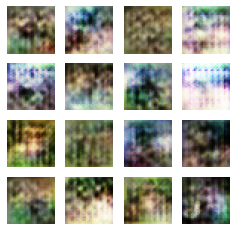

Time for training : 570 sec


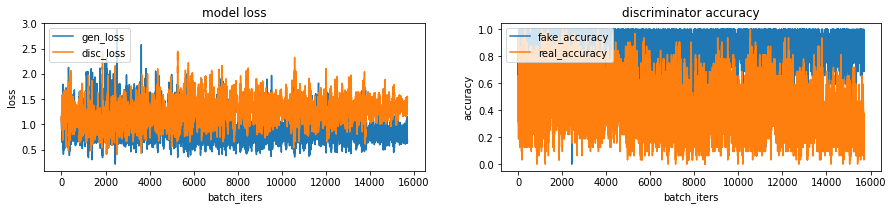

CPU times: user 8min 25s, sys: 14.4 s, total: 8min 39s
Wall time: 9min 31s


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

fake accuracy가 계속 1에 가깝게 유지된다면 
판별자를 성공적으로 속이지 못한다는 뜻

###학습과정 시각화하기 GIF

imageio 라이브러리 활용

In [ ]:
anim_file = '/content/drive/MyDrive/aiffel/dcgan_newimage/cifar10/cifar_10_dcgan.gif'

with imageio.get_writer(anim_file,mode='I') as writer:
  filenames = glob.glob('/content/drive/MyDrive/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png')
  filenames = sorted(filenames)
  last = -1
  for i, filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

!ls -l /content/drive/MyDrive/aiffel/dcgan_newimage/cifar10/cifar_10_dcgan.gif


-rw------- 1 root root 1877190 Feb 15 03:21 /content/drive/MyDrive/aiffel/dcgan_newimage/cifar10/cifar_10_dcgan.gif


##8. CHeckpoint로 이어서 학습하기

epoch를 추가 진행하거나 학습한 모델을 활용하여 이미지 생성할 때 checkpoint를 다시 불러와 쓰면 된다.

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore

generator = checkpoint.generator
discriminator = checkpoint.discriminator


In [ ]:
noise = tf.random.normal([1,100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated *255.0)
np_generated = np_generated.astype(int)


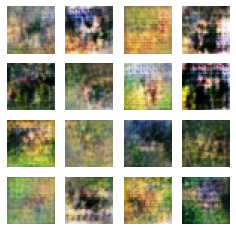

Time for training : 514 sec


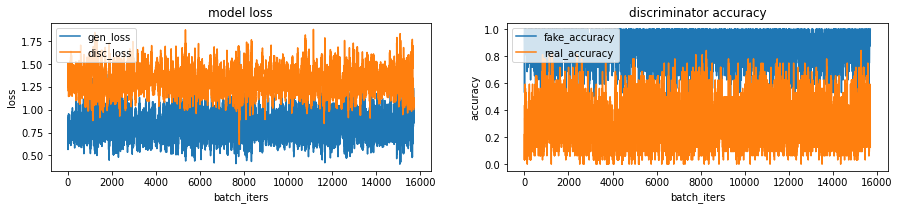

CPU times: user 8min 21s, sys: 13.4 s, total: 8min 34s
Wall time: 8min 35s


In [ ]:
'''
%%time
train(train_dataset, EPOCHS, save_every)
'''

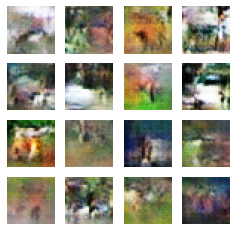

Epoch 841 | iter 101
Time for epoch 841: 2 sec


In [ ]:
'''
%%time
train(train_dataset, 1000, save_every)
'''

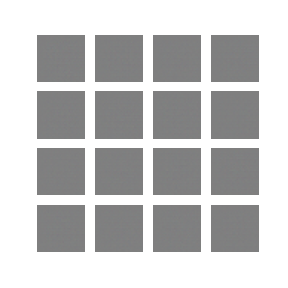

##회고
1. DCGAN은 입력값을 (64,64,)로 받는다는데 그냥 (28,28,)이나 (32,32,)로 해도 잘 나오긴하는 듯 하다.(아니면 내부적으로 바꾸나?)
2. normalization을 0,1 로 해야하는지 -1,1로 해야하는지 모르겠다. imshow() 했을 땐 0~1이 맞는 거 같은데..(activation도 sigmoid로 바꿔주었다.)

3.  노이즈 벡터의 색과 훈련된 이미지의 색이 계속 viridis 로 나와서 어떻게 해야할지 고민했다() >> plt.imshow(generated_image[0,:,:,:]) 마지막 0을 : 로 바꿨다

4. epochs = 1000으로 달리다가 코랩 용량 제한에 걸렸다
5. fake accuracy가 계속 1에 가깝더라도 early stopping 하지 않고 계속 훈련해야한다고 한다. 나중에 가서 낮아지는 경우가 있기 떄문에..